# This notebook calculates the RV and vsini from the broadening function of each Coude observation. RVs with uncertainties are calculated using a weighted average broadening function of a large number of spectral orders, and using a bootstrap resampling method to determine errors. Vsinis are calculated by fitting a rotationally broadened profile to this weighted average broadening function.

In [55]:
#package imports
#If using Jupyter locally, make sure you have pip installed saphires and any dependencies you need.
#You should have done this as part of our last lab
import saphires
import matplotlib
matplotlib.use('Qt5Agg')#comment this line out if using colab
import numpy as np
import os
from scipy.optimize import curve_fit
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.ndimage import gaussian_filter
import astropy
import pandas as pd
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from __future__ import print_function

In [56]:
#Constants
R_coude = 60000.0 #spectral resolution of the Coude.
c = (2.9979245*10**5)

### Print out all the .p files you have in your data folder for your star. These are all the broadening functions you have to analyze.  You'll need to replace the file path and starname below with your own

In [57]:
# here are all the broadening function files
!ls /Users/edinpeskovic/Documents/'research summer 2024'/'Spectroscopy Lab'/coude_SSG_data/V846Her/V846Her*.p

/Users/edinpeskovic/Documents/research summer 2024/Spectroscopy Lab/coude_SSG_data/V846Her/V846Her_2020-05-10_0_5100_4.5.p
/Users/edinpeskovic/Documents/research summer 2024/Spectroscopy Lab/coude_SSG_data/V846Her/V846Her_2020-08-06_0_5100_4.5.p
/Users/edinpeskovic/Documents/research summer 2024/Spectroscopy Lab/coude_SSG_data/V846Her/V846Her_2020-09-03_0_5100_4.5.p
/Users/edinpeskovic/Documents/research summer 2024/Spectroscopy Lab/coude_SSG_data/V846Her/V846Her_2021-03-31_0_5100_4.5.p
/Users/edinpeskovic/Documents/research summer 2024/Spectroscopy Lab/coude_SSG_data/V846Her/V846Her_2021-05-04_0_5100_4.5.p


### Here you change the filepath and name to read in the file of your choice

In [58]:
#change the file path and filename to read in your broadening function file
path= '/Users/edinpeskovic/Documents/research summer 2024/Spectroscopy Lab/coude_SSG_data/V846Her/'
filename= 'V846Her_2021-05-04_0_5100_4.5.p'
filepath= path+filename
print(str(filepath))


/Users/edinpeskovic/Documents/research summer 2024/Spectroscopy Lab/coude_SSG_data/V846Her/V846Her_2021-05-04_0_5100_4.5.p


In [59]:
#read in the pickle and smooth the broadening function to instrumental resolution
tar,tar_spec = pkl.load(open(filepath,'rb'))
tar_spec = saphires.bf.analysis(tar,tar_spec,R = R_coude)

print(tar)

['V846Her_2021-05-04_0.pkl[12][4322-4381]'
 'V846Her_2021-05-04_0.pkl[13][4381-4438]'
 'V846Her_2021-05-04_0.pkl[14][4438-4493]'
 'V846Her_2021-05-04_0.pkl[15][4499-4557]'
 'V846Her_2021-05-04_0.pkl[16][4557-4618]'
 'V846Her_2021-05-04_0.pkl[17][4618-4659]'
 'V846Her_2021-05-04_0.pkl[18][4677-4743]'
 'V846Her_2021-05-04_0.pkl[19][4746-4803]'
 'V846Her_2021-05-04_0.pkl[20][4816-4876]'
 'V846Her_2021-05-04_0.pkl[21][4879-4943]'
 'V846Her_2021-05-04_0.pkl[22][4951-5019]'
 'V846Her_2021-05-04_0.pkl[23][5026-5084]'
 'V846Her_2021-05-04_0.pkl[24][5100-5161]'
 'V846Her_2021-05-04_0.pkl[25][5176-5245]'
 'V846Her_2021-05-04_0.pkl[26][5256-5326]'
 'V846Her_2021-05-04_0.pkl[27][5334-5412]'
 'V846Her_2021-05-04_0.pkl[28][5416-5499]'
 'V846Her_2021-05-04_0.pkl[29][5502-5574]'
 'V846Her_2021-05-04_0.pkl[30][5596-5672]'
 'V846Her_2021-05-04_0.pkl[31][5689-5767]'
 'V846Her_2021-05-04_0.pkl[32][5786-5868]'
 'V846Her_2021-05-04_0.pkl[33][5882-5950]'
 'V846Her_2021-05-04_0.pkl[34][5994-6069]'
 'V846Her_2

### check starname_coude_head.dat (e.g. V846Her_coude_head.dat) and supply the barycentric RV correction and BJD here for your observation.

In [60]:
V846Her_df = pd.read_csv('/Users/edinpeskovic/Documents/research summer 2024/Spectroscopy Lab/coude_SSG_data/V846Her/V846Her_coude_head.dat')
V846Her_df.head()

,#Name,Tele,DATE-OBS,EXPTIME,BJD,BVCORR
V846Her_2020-05-10_0.pkl,mcdonald,2020-05-10T08:34:29.059,0,576.218,2.458980e+06,3.623
V846Her_2020-08-06_0.pkl,mcdonald,2020-08-06T04:38:51.056,1,635.211,2.459068e+06,-20.178
V846Her_2020-09-03_0.pkl,mcdonald,2020-09-03T03:29:05.177,2,189.695,2.459096e+06,-20.547
V846Her_2021-03-31_0.pkl,mcdonald,2021-03-31T09:13:27.100,3,1217.479,2.459305e+06,16.139
V846Her_2021-05-04_0.pkl,mcdonald,2021-05-04T07:05:10.178,4,224.676,2.459339e+06,5.994


In [61]:
#A barycentric correction corrects for differences in the Earth's position with respect to the
#barycenter of the Solar System.
BVCORR = 5.994
BJD = 2459339

### Make a plot of your broadening functions, then create an average broadening function across all orders weighted by the background noise.

In [62]:
tar_spec.keys()

dict_keys(['V846Her_2021-05-04_0.pkl[12][4322-4381]', 'V846Her_2021-05-04_0.pkl[13][4381-4438]', 'V846Her_2021-05-04_0.pkl[14][4438-4493]', 'V846Her_2021-05-04_0.pkl[15][4499-4557]', 'V846Her_2021-05-04_0.pkl[16][4557-4618]', 'V846Her_2021-05-04_0.pkl[17][4618-4659]', 'V846Her_2021-05-04_0.pkl[18][4677-4743]', 'V846Her_2021-05-04_0.pkl[19][4746-4803]', 'V846Her_2021-05-04_0.pkl[20][4816-4876]', 'V846Her_2021-05-04_0.pkl[21][4879-4943]', 'V846Her_2021-05-04_0.pkl[22][4951-5019]', 'V846Her_2021-05-04_0.pkl[23][5026-5084]', 'V846Her_2021-05-04_0.pkl[24][5100-5161]', 'V846Her_2021-05-04_0.pkl[25][5176-5245]', 'V846Her_2021-05-04_0.pkl[26][5256-5326]', 'V846Her_2021-05-04_0.pkl[27][5334-5412]', 'V846Her_2021-05-04_0.pkl[28][5416-5499]', 'V846Her_2021-05-04_0.pkl[29][5502-5574]', 'V846Her_2021-05-04_0.pkl[30][5596-5672]', 'V846Her_2021-05-04_0.pkl[31][5689-5767]', 'V846Her_2021-05-04_0.pkl[32][5786-5868]', 'V846Her_2021-05-04_0.pkl[33][5882-5950]', 'V846Her_2021-05-04_0.pkl[34][5994-6069]', 

(-100.0, 100.0)

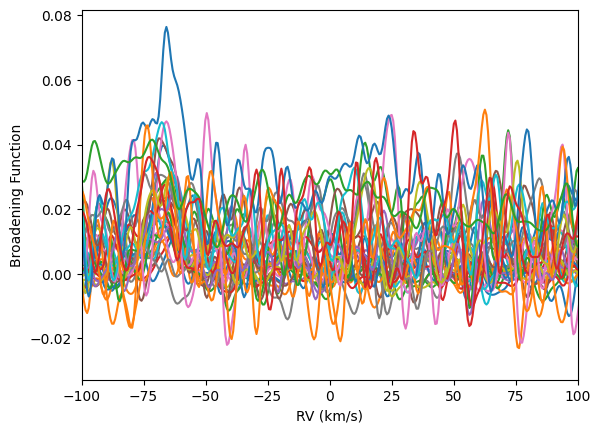

In [63]:
#plot all of the spectral orders considered in the analysis
fig,ax = plt.subplots(1)

for i in range(tar.size):
    ax.plot(tar_spec[tar[i]]['vel'],tar_spec[tar[i]]['bf_smooth'])

ax.set_xlabel('RV (km/s)')
ax.set_ylabel('Broadening Function')
plt.xlim(-100, 100)

In [64]:
#compute a weighted average broadening function profile
#Remember that we are assuming the region +/- 150 km/s is the "background" of the BF.
#Does this seem reasonable for your observation?
vel,bf,bf_sterr,bf_wstd = saphires.bf.weight_combine(tar,tar_spec,vel_gt_lt=(+150,-150))


Text(0.5, 1.0, 'Target broadening function')

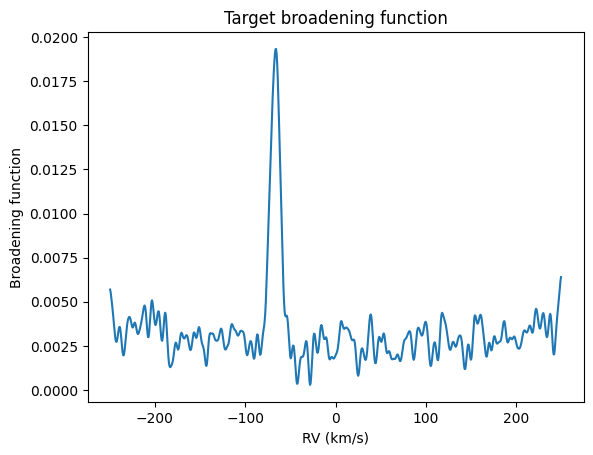

In [65]:
fig, ax = plt.subplots(1)

ax.plot(vel, bf)
ax.set_xlabel('RV (km/s)')
ax.set_ylabel('Broadening function')
ax.set_title('Target broadening function')

(797, 1)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 400. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a b

Text(0.5, 1.0, 'Target broadening function')

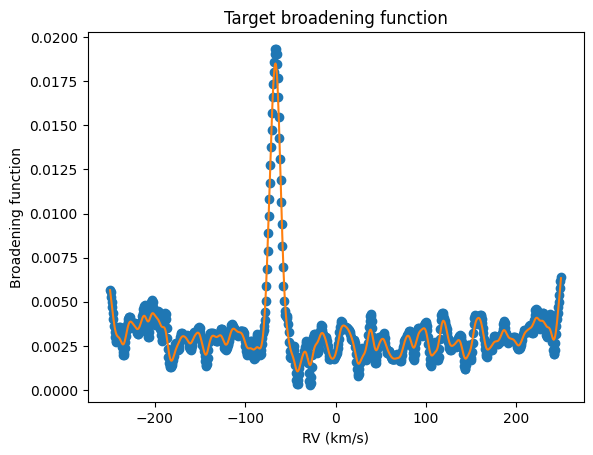

In [55]:
#gaussian fit using scikit learn Gaussian Process Regressor
kernel = ConstantKernel() + Matern(length_scale=2, length_scale_bounds=(-400, 400), nu=3/2) + WhiteKernel(noise_level=1) #A kernel describes the covariance of the Guassian 
#process random variables. The GP kernel can be specified as the sum of the components of the Matern component, an amplitude factor 
#the ConstantKernel, and well as the Observation noise (WhiteKernel)

X = vel.reshape(-1,1) #scikit-learn API expects a 2D numpy array
print(X.shape)

gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X, bf) #fits our 2D array of data 

gp.kernel_

x_pred = X
y_pred, sigma = gp.predict(x_pred, return_std=True)

gp.get_params()

fig, ax = plt.subplots(1)

ax.plot(vel, bf, 'o')
ax.plot(x_pred,y_pred)
ax.set_xlabel('RV (km/s)')
ax.set_ylabel('Broadening function')
ax.set_title('Target broadening function')

In [77]:
print(np.max(bf))
print(np.interp(np.max(bf), bf, vel))

0.01932695684746952
249.34297165542162


# Use the plot above to supply an initial guess of p0
# THIS WILL LIKELY CHANGE FOR EACH OBSERVATION

# Then you can just run the code below and it will measure the RV with error from our bootstrap and calculate the vsini of your star



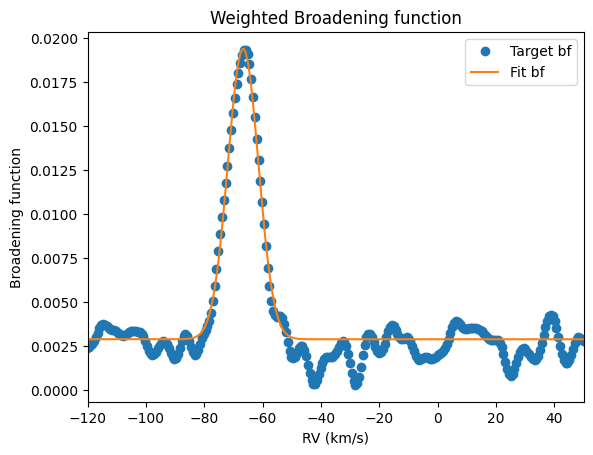

In [41]:
#Use the plot above to supply an initial guess of p0 for your observation.
#You need to change this to match each observation you analyze
#Parameters are in order Amplitude, RV, sigma, offset
p0=(0.05,-80,10,0)
fit,covar = curve_fit(saphires.utils.gaussian_off,vel,bf,p0)

fig, ax = plt.subplots(1)
ax.plot(vel, bf, 'o', label = 'Target bf')
ax.plot(vel, saphires.utils.gaussian_off(vel, *fit),label = 'Fit bf')
ax.set_xlim(-120,50)
ax.set_xlabel('RV (km/s)')
ax.set_ylabel('Broadening function')
ax.set_title('Weighted Broadening function')
ax.legend()

In [13]:
#use our bootstrap method to sample orders with replacement.
n_boot = 500 #number of bootstrap interations to perform
rv_boot_dist = np.zeros(n_boot) #a blank array of RV values to fill
bf_boot_dist = np.zeros([n_boot,tar_spec[tar[0]]['vel'].size]) #an array to save the BFs we create
for i in range(n_boot):
    rindwr = np.random.randint(0,tar.size,tar.size) #randomly sample the contributing orders with replacement.
    tar_i = tar[rindwr] #pick out the selected orders
    vel_i,bf_i,bf_ste_i,bf_wstd_i = saphires.bf.weight_combine(tar_i,tar_spec,vel_gt_lt=(+150,-150)) #create a version of the combined BF
    fit_i = (curve_fit(saphires.utils.gaussian_off,vel_i,bf_i,p0=p0))[0] #fit it
    rv_boot_dist[i] = fit_i[1] #save the RV
    bf_boot_dist[i,:] = bf_i


rv_boot_16,rv_boot_med,rv_boot_84 = np.percentile(rv_boot_dist,[16,50,84])
rv_booterr_lo = rv_boot_med - rv_boot_16
rv_booterr_hi = rv_boot_84 - rv_boot_med

Text(0, 0.5, 'N')

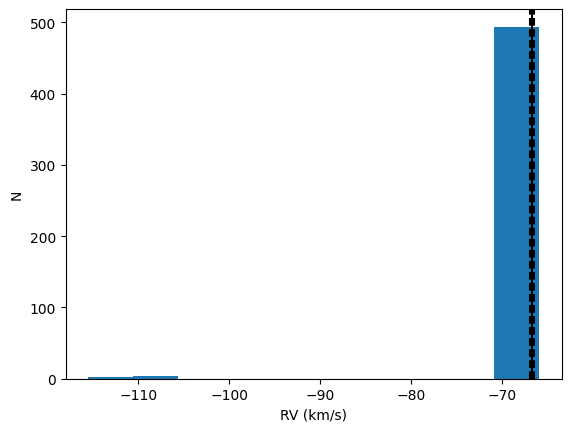

In [14]:
fig, ax = plt.subplots(1)
ax.hist(rv_boot_dist)
ax.axvline(rv_boot_16, color = 'k', ls='--')
ax.axvline(rv_boot_med, color = 'k', ls='-')
ax.axvline(rv_boot_84, color = 'k', ls = '--')
ax.set_xlabel('RV (km/s)')
ax.set_ylabel('N')

### The final step is to apply a barycentric correction that accounts for the motion of the earth about the barycenter of the solar system. This correction is given in the header file for the observations ('starname_coude_head.dat') and you should have supplied at the beginning of the notebook when you read in your file.

### Note that the error on this correction is extremely small compared to our measurement precision, so we will not worry about propogating this uncertainty.

In [15]:
print('RV (uncorrected):',np.round(rv_boot_med,2),'+',np.round(rv_booterr_hi,2),'-',np.round(rv_booterr_lo,2))

### Last step, convert to barcentric RV. This has already been computed and is in the starname_coude_head.dat file.
brv_boot = (rv_boot_med) + BVCORR + ((rv_boot_med) * BVCORR / c)
print('RV (barycenter corrected):',np.round(brv_boot,2),'+',np.round(rv_booterr_hi,2),'-',np.round(rv_booterr_lo,2))### Last step, convert to barcentric RV. This has already been computed and is in the starname_coude_head.dat file.


RV (uncorrected): -66.65 + 0.21 - 0.24
RV (barycenter corrected): -60.66 + 0.21 - 0.24


## Now lets fit a rotationally broadened line profile model to our broadening function to measure RV.

### Here instead of fitting the broadening function with a simple Gaussian, we are computing a synthetic rotationally broadened line profile and fitting that to the observed broadening function. Essentially, this relates the width of our broadening function to the actual rotation velocity of the star (v) times the sin of the inclination angle (i) of the axis of rotation relative to us. This gives us a projected rotational velocity, or vsini.

In [16]:
#this function creates the rotationally broadened line profile function for a given set of additonal broadening sources.
#You don't need to change anything here
def make_rot_pro(R,micro_turb,macro_turb,R_smooth,R_syn):
    '''
    A function to make a specific rotationally broadened fitting
    function for a given spectral resolution.
    '''

    if R >0:
        FWHM = (2.997924*10**5)/R
        sig_R = FWHM/(2.0*np.sqrt(2.0*np.log(2.0)))
    else:
        sig_R = 0

    if R_smooth > 0:
        FWHM_Rs = (2.997924*10**5)/R_smooth
        sig_Rs = FWHM_Rs/(2.0*np.sqrt(2.0*np.log(2.0)))
    else:
        sig_Rs = 0

    if R_syn > 0:
        FWHM_Rsyn = (2.997924*10**5)/R_syn
        sig_Rsyn = FWHM_Rsyn/(2.0*np.sqrt(2.0*np.log(2.0)))
    else:
        sig_Rsyn = 0

    sig = np.sqrt(sig_R**2 + sig_Rs**2 + micro_turb**2 + macro_turb**2 - sig_Rsyn**2)

    def rot_pro_ip(x,A,rv,rvw,o):
        '''
        Rotational line broadening function.

        To produce an actual line profile, you have to convolve this function
        with an acutal spectrum.

        In this form it can be fit directly to a the Broadening Fucntion.

        This is in velocity so if you're going to convolve this with a spectrum make sure
        to take the appropriate cautions, whatever they may be.
        '''
        e = 0.75 # Limb-Darkening Coefficient

        c1 = (2*(1-e))/(np.pi*rvw*(1-e/3.0))
        c2 = e/(2*rvw*(1-e/3.0))

        prof=A*(c1*np.sqrt(1-((x-rv)/rvw)**2)+c2*(1-((x-rv)/rvw)**2))+o

        prof[np.isnan(prof)] = o

        v_spacing = x[1]-x[0]

        smooth_sigma = sig/v_spacing

        prof_conv=gaussian_filter(prof,sigma=smooth_sigma)

        return prof_conv

    return rot_pro_ip

In [17]:
#then you will use curve_fit to fit a rotational broadening profile to the broadening function.
#You should not need to change anything in this cell for different observations
rot_prof = make_rot_pro(R_coude,0,0,R_coude,0)
fit_rp,covar_rp = curve_fit(rot_prof,vel,bf,p0=p0)
print(fit_rp)


[ 2.12918245e-01 -6.66804048e+01  8.40889733e+00  2.88850107e-03]


### Plot the broadening function and the model fit. Does it look like a good match?

Text(0, 0.5, 'Broadening Function')

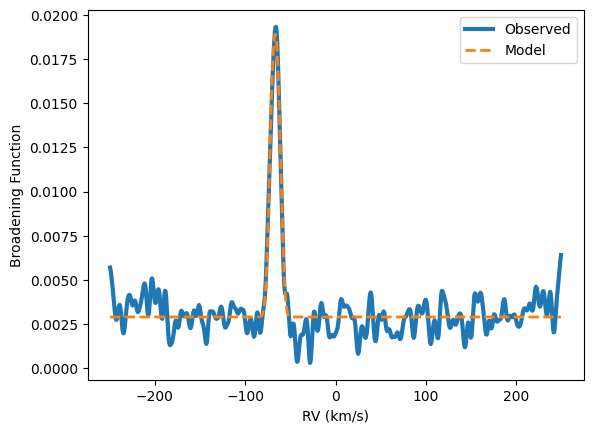

In [18]:
fig,ax = plt.subplots(1)

ax.plot(vel,bf, label= "Observed", lw=3)
ax.plot(vel,rot_prof(vel,*fit_rp), '--', lw= 2, label= "Model")
plt.legend()
ax.set_xlabel('RV (km/s)')
ax.set_ylabel('Broadening Function')


In [19]:
#print the results of the above fit
vsini1_lsfit = fit_rp[2]
vsini1err_lsfit = np.sqrt(covar_rp[2,2]) #note we are taking the error on the vsini to be the sqrt of the diagonal term in the covariance matrix
print('RV:',np.round(rv_boot_med,2),'+',np.round(rv_booterr_hi,2),'-',np.round(rv_booterr_lo,2), 'km/s')
print('vsini:',np.round(vsini1_lsfit,2),'+/-',np.round(vsini1err_lsfit,2), 'km/s')

RV: -66.65 + 0.21 - 0.24 km/s
vsini: 8.41 +/- 0.26 km/s


### Record the filename, BJD, vsini, RV (barycenter corrected), and associated errors in a machine-readable table.

In [132]:
f = open("RV_V846Her.txt", "a") #change the file name here to whatever you would like.
#The "a" means you can append to the table, so every time you run this command it will add a new line

print(filename, BJD, np.round(brv_boot,2),np.round(rv_booterr_hi,2),np.round(rv_booterr_lo,2),np.round(vsini1_lsfit,2),np.round(vsini1err_lsfit,2), file=f)
f.close()

# Run the above code on all 8-12 of your observations. Then write some of your own code to do the following and answer the following questions:

### 1) Read in your table of data and make a plot of your RVs over time using the Barycentric Julian Date (BJD). Include error bars on your RV data points and make the plot look nice with proper labels, etc.

In [23]:
V846Her_RV_vsini = pd.read_csv('/Users/edinpeskovic/Documents/research summer 2024/Spectroscopy Lab/Notebooks:code/RV_V846Her.txt', sep =' ', names = ["Observation File", "BJD", "Radial Velocity", "+ error", "- error", "vsini", "vsini error"])
V846Her_RV_vsini #exclude the last .p file cuz the data is dog shit

,Observation File,BJD,Radial Velocity,+ error,- error,vsini,vsini error
0,V846Her_2020-05-10_0_5100_4.5.p,2458980,-58.54,0.05,0.06,8.81,0.04
1,V846Her_2020-08-06_0_5100_4.5.p,2459068,-36.57,0.05,0.06,8.92,0.03
2,V846Her_2020-09-03_0_5100_4.5.p,2459096,-25.60,0.06,0.06,8.87,0.03
3,V846Her_2021-03-31_0_5100_4.5.p,2459305,-27.38,0.05,0.05,8.89,0.05


In [29]:
#THIS CODE DELTES A SPECIFIC LINE, in this case, the file from 2021-05-04 cuz data was bad
#with open('/Users/edinpeskovic/Documents/research summer 2024/Spectroscopy Lab/Notebooks:code/RV_V846Her.txt', 'r') as f:
#    data = f.readlines()

#with open('/Users/edinpeskovic/Documents/research summer 2024/Spectroscopy Lab/Notebooks:code/RV_V846Her.txt', 'w') as f:
#    for line in data:
#        if line.strip("\n") != "V846Her_2021-05-04_0_5100_4.5.p 2459339 -60.67 0.2 0.26 8.41 0.26":
#            f.write(line)

<function matplotlib.pyplot.show(close=None, block=None)>

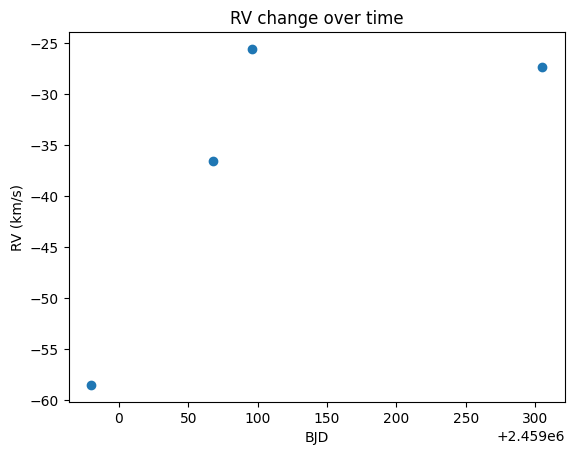

In [25]:
RV_V846Her = V846Her_RV_vsini["Radial Velocity"].to_numpy()
vsini_V846Her = V846Her_RV_vsini["vsini"].to_numpy()
BJD_V846Her = V846Her_RV_vsini["BJD"].to_numpy()

fig, ax = plt.subplots(1)

ax.plot(BJD_V846Her, RV_V846Her, 'o')
ax.set_xlabel("BJD")
ax.set_ylabel("RV (km/s)")
ax.set_title("RV change over time")
plt.show

### 2) Do a calculation to check whether the RVs vary by more than expected given the measurement precision of the RVs. If so, you have a binary system!



In [26]:
avg_RV_V846Her = np.average(RV_V846Her)
print("average RV of V846Her is", avg_RV_V846Her, "km/s")

std_RV_V846Her = np.std(RV_V846Her)
print("standard deviation of RV is", std_RV_V846Her)


average RV of V846Her is -37.0225 km/s
standard deviation of RV is 13.102088335452482


### 3) Compute the mean and standard deviation of your vsini measurements. Is the standard deviation of the sample reasonable given the error we calculated for each individual vsini measurement?

In [27]:
avg_vsini_V846Her = np.average(vsini_V846Her)
print("average vsini of V846Her is", avg_vsini_V846Her, "km/s")

std_vsini_V846Her = np.std(vsini_V846Her)
print("standard deviation of vsini is", std_vsini_V846Her)

average vsini of V846Her is 8.8725 km/s
standard deviation of vsini is 0.040233692348577564


### 4) Compute the error on the mean value of your vsini measurements (sigma/sqrt(N)). This is our best measurement of the vsini value for the star, assuming the rotation of the star is not varying.

In [28]:
avg_RV_err = std_RV_V846Her/np.sqrt(5)
print("error on the average RV is +/-", avg_RV_err)

avg_vsini_err = std_vsini_V846Her/np.sqrt(5)
print("error on the average vsini is +/-", avg_vsini_err)

error on the average RV is +/- 5.859432033055763
error on the average vsini is +/- 0.01799305421544652


In [ ]:
make sure it saved

### 6) In light of your RV measuremts for each observation, go back and check your line identifications in Part 1 of this lab. Are they correct? If you need to revise your line identifications or measurements, upload the new version with this lab as well.